In [102]:
import requests
import pandas as pd
import numpy as np

In [103]:
def get_adjudicators(adj_url):
    adjudicators_map = {}

    response = requests.get(adj_url)

    for adj in response.json():
        adj_id = adj['id']
        adj_name = adj['name']
        adjudicators_map[str(adj_id)] = adj_name

    return adjudicators_map

In [ ]:
def get_scores_from_ballots(api_url):
    tournaments = requests.get(f'{api_url}/tournaments').json()

    df = pd.DataFrame()

    for tournament in tournaments:
        tournament_slug = tournament['slug']

        adj_url = f'{api_url}/tournaments/{tournament_slug}/adjudicators'
        adjudicators_map = get_adjudicators(adj_url)

        rounds = requests.get(f'{api_url}/tournaments/{tournament_slug}/rounds').json()
        for round in rounds: 
            round_seq = round['seq']
            pairings = requests.get(f'{api_url}/tournaments/{tournament_slug}/rounds/{round_seq}/pairings').json()

            for pairing in pairings: 
                pairing_id = pairing['id']
                ballots = requests.get(f'{api_url}/tournaments/{tournament_slug}/rounds/{round_seq}/pairings/{pairing_id}/ballots').json()

                for ballot in ballots:
                    adj_url = ballot['participant_submitter']
                    adj_id = adj_url.split('/')[-1]
                    adj_name = adjudicators_map[str(adj_id)]

                    sheets = ballot['result']['sheets']
                    for sheet in sheets: 
                        for team in sheet['teams']:
                            if 'speeches' not in team:
                                print('Skippping because team has no speeches', team)
                                continue
                            for speech in team['speeches']:
                                score = speech['score']

                                row = {
                                    'tournament': tournament_slug,
                                    'round': round_seq,
                                    'pairing': pairing_id,
                                    'score': score,
                                    'adj': adj_name
                                }

                                df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    
    return df


In [ ]:
search_space = ('stockholmopen2025', )

In [ ]:
df = pd.DataFrame()

for slug in search_space:
    api_url = f'https://{slug}.calicotab.com/api/v1'
    slug_df =  get_scores_from_ballots(api_url)
    df = pd.concat([df, slug_df], ignore_index=True)

Skippping because team has no speeches {'side': 'og', 'points': None, 'win': True, 'score': None, 'team': 'https://stockholmopen2025.calicotab.com/api/v1/tournaments/stockholm2025/teams/242209'}
Skippping because team has no speeches {'side': 'oo', 'points': None, 'win': False, 'score': None, 'team': 'https://stockholmopen2025.calicotab.com/api/v1/tournaments/stockholm2025/teams/242211'}
Skippping because team has no speeches {'side': 'cg', 'points': None, 'win': False, 'score': None, 'team': 'https://stockholmopen2025.calicotab.com/api/v1/tournaments/stockholm2025/teams/242218'}
Skippping because team has no speeches {'side': 'co', 'points': None, 'win': False, 'score': None, 'team': 'https://stockholmopen2025.calicotab.com/api/v1/tournaments/stockholm2025/teams/242215'}


In [111]:
df.head(10)

,tournament,round,pairing,score,adj
0,stockholm2025,1,396394,73.0,Andrew Mabon
1,stockholm2025,1,396394,72.0,Andrew Mabon
2,stockholm2025,1,396394,74.0,Andrew Mabon
3,stockholm2025,1,396394,73.0,Andrew Mabon
4,stockholm2025,1,396394,77.0,Andrew Mabon
5,stockholm2025,1,396394,78.0,Andrew Mabon
6,stockholm2025,1,396394,73.0,Andrew Mabon
7,stockholm2025,1,396394,73.0,Andrew Mabon
8,stockholm2025,1,396395,74.0,Daryna Ivanitska
9,stockholm2025,1,396395,75.0,Daryna Ivanitska


In [ ]:
by_adj = df.groupby('adj')

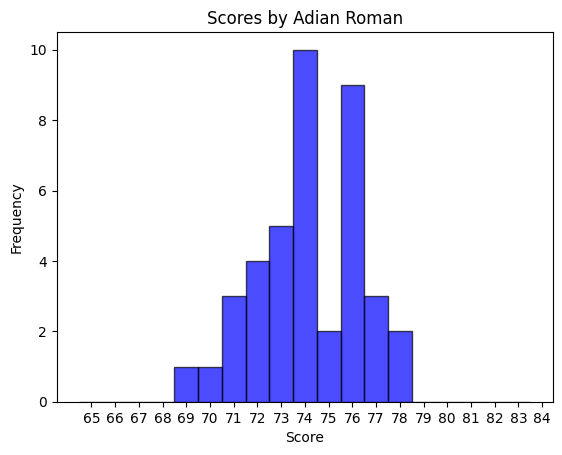

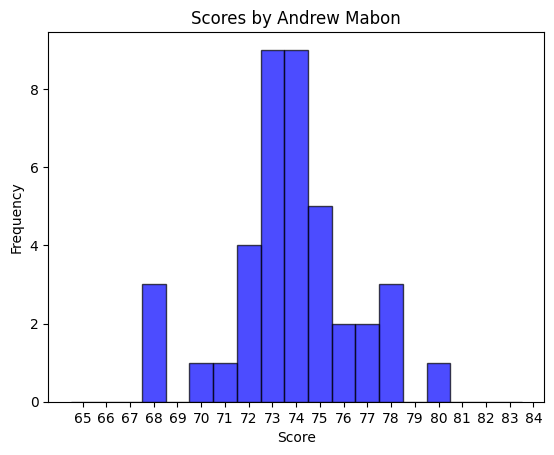

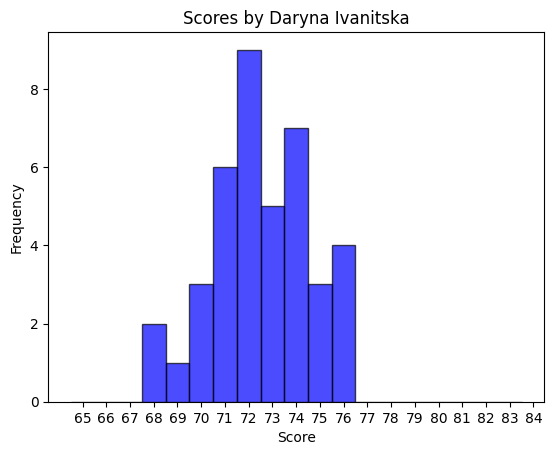

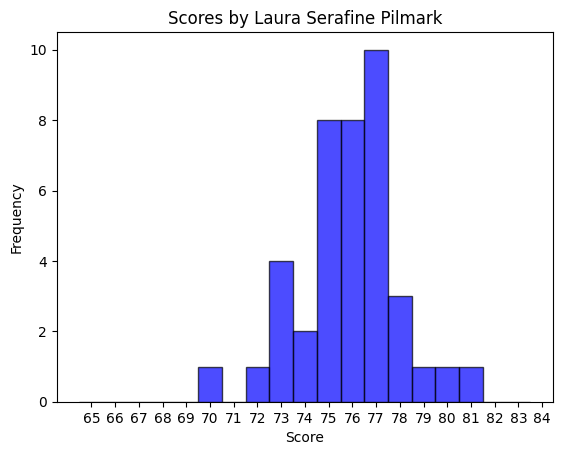

In [119]:
import matplotlib.pyplot as plt

bp_bins = np.arange(65, 85, 1)

# Group by adjudicator and plot histogram of scores
for judge, group in df.groupby('adj'):
    plt.figure()  # Create a new figure for each judge
    plt.title(f'Scores by {judge}')
    plt.hist(group['score'], alpha=0.7, color='blue', bins=bp_bins, align='left', edgecolor='black')
    plt.xticks(bp_bins)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

([<matplotlib.axis.XTick at 0x10efe7a40>,
 [Text(65, 0, '65'),
  Text(66, 0, '66'),
  Text(67, 0, '67'),
  Text(68, 0, '68'),
  Text(69, 0, '69'),
  Text(70, 0, '70'),
  Text(71, 0, '71'),
  Text(72, 0, '72'),
  Text(73, 0, '73'),
  Text(74, 0, '74'),
  Text(75, 0, '75'),
  Text(76, 0, '76'),
  Text(77, 0, '77'),
  Text(78, 0, '78'),
  Text(79, 0, '79'),
  Text(80, 0, '80'),
  Text(81, 0, '81'),
  Text(82, 0, '82'),
  Text(83, 0, '83'),
  Text(84, 0, '84')])

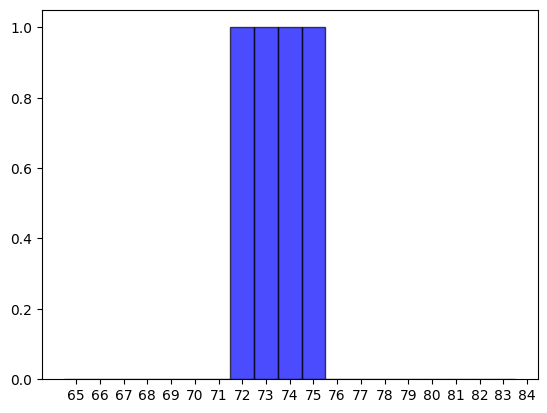

In [130]:
by_adj = df.groupby('adj')
means = by_adj['score'].mean()
plt.hist(means, alpha=0.7, color='blue', bins=bp_bins, align='left', edgecolor='black')
plt.xticks(bp_bins)

## Meta
- target the paper towards audience not familiar with debates (easier peer reviews)

## Showing the problem
Intuitively: A speaker can get either a 79 or 74 with the same speech, depending on the judge.

What is an average speaker's expected standard deviation? Could be calculated by taking an average across all individual speakers st. devs.
(Is this actually reliable/useful?)

Things to show: 
1. The distribution of judges' means is spread out.
2. The distribution of an individual judge's mean is not as spread out.

-> Judges have inherent internal inconsistency as compared to each other that other factors cannot account for.

## Solving the problem




adj
Adian Roman               2.178567
Andrew Mabon              2.635921
Daryna Ivanitska          2.099908
Laura Serafine Pilmark    2.118902
Name: score, dtype: float64

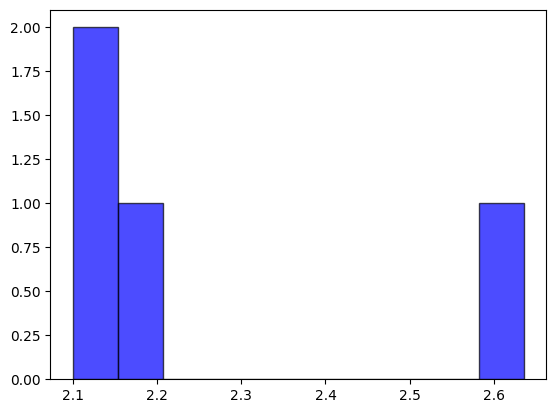

In [131]:
stds = by_adj['score'].std()
plt.hist(stds, alpha=0.7, color='blue', edgecolor='black')
stds

Text(0, 0.5, 'Standard Deviation of Scores')

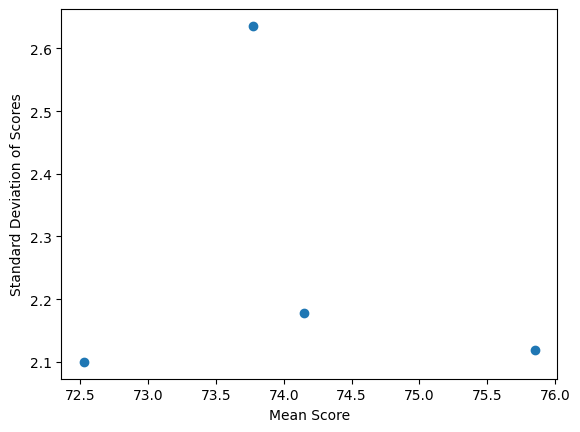

In [133]:
plt.scatter(means, stds)
plt.xlabel('Mean Score')

plt.ylabel('Standard Deviation of Scores')

In [ ]:
# speaker scores by judge
# pandas dataframe model
# score, speaker_id, judge_id, round_seq, pairing_id,  

# Questions to answer
# 1. Do judges at better tournaments give more consistent means? 

# monte carlo on wsdc 2023 for tetsing judge subsets, gives rough means distributions
# should we also standardize by  